In [1]:
import pandas as pd
import seaborn as se
import pickle
from collections import Counter
import numpy as np
import os
import pickle
from timeit import timeit
import json
from timeit import default_timer as timer
from pathlib import Path
import shutil
import math
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt


In [2]:
se.set_style("darkgrid")

Text(0.5, 1.0, 'Bandwidth distribution')

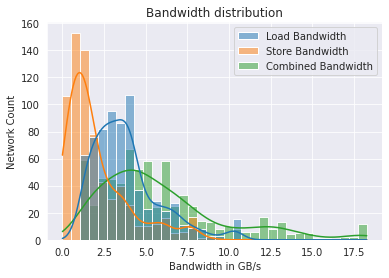

In [14]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

bw_df = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['load_bw', 'store_bw'])].div(2**30)
bw_df["combined"] = bw_df["load_bw"] + bw_df["store_bw"]
bw_df = bw_df.rename(columns={'load_bw': "Load Bandwidth", "store_bw": "Store Bandwidth", "combined":"Combined Bandwidth"})
plt = se.histplot(data = bw_df, kde=True)
plt.set_xlabel('Bandwidth in GB/s')
plt.set_ylabel('Network Count')
plt.set_title('Bandwidth distribution')

Text(0.5, -0.3, 'Reason for layers experiencing Speedup < 1 over CPU Baseline')

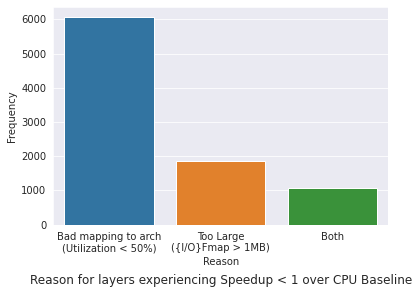

In [54]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_metrics = pd.read_csv(
    "../data/layer_metrics.csv",
    index_col=[0, 1],
)
arch_metrics = arch_metrics[arch_metrics["speedup"] < 1]
layer_metrics = layer_metrics[layer_metrics.index.isin(arch_metrics.index)]
slow_layers = arch_metrics.join(layer_metrics)
slow_layers["ifmap_huge"] = slow_layers["ifmap_mem_size"] > 2**20
slow_layers["ofmap_huge"] = slow_layers["ofmap_mem_size"] > 2**20
slow_layers["layer_huge"] = (slow_layers["ifmap_mem_size"] > 2**20) & (slow_layers["ofmap_mem_size"] > 2**20)
slow_layers["low_util"] = slow_layers["util"] < 0.5
slow_layers["high_util"] = slow_layers["util"] > 0.95

bad_mapping = len(slow_layers[slow_layers["util"] < 0.5])
too_large = len(
    slow_layers[
        (slow_layers["ifmap_huge"] == True) | (slow_layers["ofmap_huge"] == True)
    ]
)
both = len(
    slow_layers[
        ((slow_layers["ifmap_huge"] == True) | (slow_layers["ofmap_huge"] == True))
        & (slow_layers["util"] < 0.5)
    ]
)

counts = pd.DataFrame(
    {
        "Reason": [
            "Bad mapping to arch\n(Utilization < 50%)",
            "Too Large\n({I/O}Fmap > 1MB)",
            "Both",
        ],
        "Frequency": [bad_mapping, too_large, both],
    }
)
plt = se.barplot(data=counts, x="Reason", y="Frequency")
plt.set_title("Reason for layers experiencing Speedup < 1 over CPU Baseline", y=-0.3)

Text(0.5, -0.3, 'Types of layers with Utilizationl < 50%, speedup < 1 and small memory footprint')

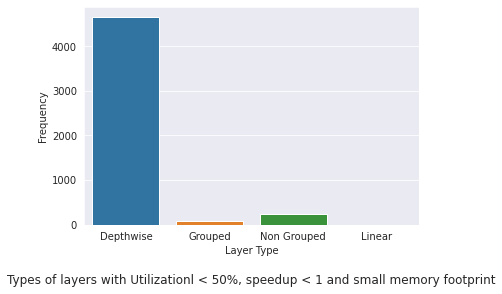

In [55]:
layer_metrics = pd.read_csv('../data/layer_metrics.csv', index_col=[0, 1])
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)
aggregate_metrics = arch_metrics.join(layer_metrics)
layers = aggregate_metrics[['util', 'ifmap_mem_size', 'speedup', 'ofmap_mem_size']]
layers = layers[(layers['ifmap_mem_size'] < 2**20)]
layers = layers[(layers['ofmap_mem_size'] < 2**20)]
layers = layers[(layers['speedup'] < 1)]
layers = layers[(layers['util'] < 0.5)]

layers = aggregate_metrics[arch_metrics.index.isin(layers.index)]
depthwise_layers = len(layers[layers['groups'] == layers['channels']])
grouped_conv_layers = len(layers[(layers['groups'] != layers['channels']) & (layers['groups'] > 1)])
conv_layers = len(layers[(layers['groups'] == 1)])
non_conv_layers = len(layers[layers['type'] != 'conv'])

counts = pd.DataFrame({
    'Layer Type': ['Depthwise', 'Grouped', 'Non Grouped', 'Linear'],
    'Frequency': [depthwise_layers, grouped_conv_layers, conv_layers, non_conv_layers],
})
plt = se.barplot(data = counts, x='Layer Type', y = 'Frequency')
plt.set_title("Types of layers with Utilizationl < 50%, speedup < 1 and small memory footprint", y = -0.3)